In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from miniml.ann import *
from miniml.ann.common import *
from miniml.ann.utils import *

In [2]:
embedding_size = 2

sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
                "dog cat animal", "cat monkey animal", "monkey dog animal"]

word_sequence = " ".join(sentences).split()
word_list = list(set(word_sequence))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_list)

In [3]:
# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    for w in context:
        skip_grams.append([target, w])
skip_grams = np.array(skip_grams)

In [4]:
W1 = np.random.randn(voc_size, embedding_size)
W2 = np.random.randn(embedding_size, voc_size)

x_node, y_node = Placeholder(), Placeholder()

W1_node = Placeholder()
W2_node = Placeholder()

l1 = Linear(x_node, W1_node, None)
l2 = Linear(l1, W2_node, None)
mse = MSE(y_node, l2)

In [5]:
feed_dict = {
    W1_node: W1,
    W2_node: W2
}

graph = feed_dict_2_graph(feed_dict)    # network graph
sorted_graph = topology(graph)          # sorted graph
trainables = [W1_node, W2_node]

In [6]:
optimizer = 'Adam'
lr=1e-3
epochs=1000
batch_size = 2

steps_per_epoch = len(skip_grams) // batch_size
losses = []

# only used for Adam
it = 0

for i in range(1, epochs+1):
    loss = 0
    for j in range(steps_per_epoch):
        it += 1
        # Step 4.1: x and y need to be one hot
        rand_idx = np.random.choice(range(voc_size), batch_size, replace=False)
        xy = skip_grams[rand_idx]
        x_node.value = np.eye(voc_size)[xy[:,0]]
        y_node.value = np.eye(voc_size)[xy[:,1]]

        # Step 4.2: forward
        for n in sorted_graph:
            n.forward()

        # Step 4.3: backward
        for n in sorted_graph[::-1]:
            n.backward()

        # Step 4.4: optimization
        for t in trainables:
            t.optimize(optimizer=optimizer, lr=lr, it=it)

        # Step 5: update current loss
        loss += sorted_graph[-1].value

    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.4f}".format(i, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

Epoch: 100, Loss: 0.1344
Epoch: 200, Loss: 0.0862
Epoch: 300, Loss: 0.0628
Epoch: 400, Loss: 0.0656
Epoch: 500, Loss: 0.0623
Epoch: 600, Loss: 0.0500
Epoch: 700, Loss: 0.0615
Epoch: 800, Loss: 0.0515
Epoch: 900, Loss: 0.0639
Epoch: 1000, Loss: 0.0424


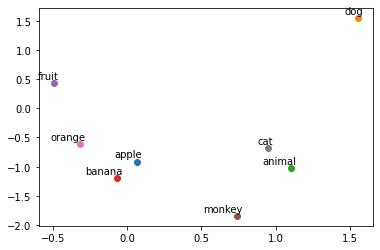

In [7]:
for i, label in enumerate(word_list):
    x, y = W1_node.value[i][0], W1_node.value[i][1]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')